# Healthcare on the Move: Patterns and Predictors of Medical Professional Migration in OECD Countries
**Eli Adrian**, (student id: 90293598)\
**Wuyang Ren**, (student id: 87924817)\
**Pierre Lambelet**, (student id: 46419362)\
**Angelo Mladineo**, (student id: 61846507)

## Introduction

The Government of Canada states that health is an inalienable human right, crucial for sustainable development, economic prosperity, and poverty eradication, as well as being an indicator of a country's progress as health increases the likelihood for sustained growth ([Global Affairs Canada](https://www.international.gc.ca/world-monde/issues_development-enjeux_developpement/global_health-sante_mondiale/health_development-sante_developpement.aspx?lang=eng), 2017), and it is through healthcare systems where governments directly administer the health of a nation. Therefore, it is imperative to study healthcare systems, find patterns among their characteristics, and evaluate their performance constantly, to improve health outcomes for all citizens.

The purpose of this project is to analyze a key aspect of healthcare systems: the national background of healthcare workers. Such that we can check if there is a significant impact on the performance of healthcare systems because of the  background of its medical professionals. 
We will focus on OECD countries specifically, because they have a comprehensive database among them, from which patterns of migration and healthcare systems' performance can be observed.
For example, the latest OECD annual report on migration mentions that migration into OECD countries, in addition to employment of foreigners within them, has reached record high levels in 2022 ([OECD](https://www.oecd.org/migration/international-migration-outlook-1999124x.htm), 2023). 

Thus, in order to explore the impact of medical professionals backgrounds', this research project is divided into three points of interest with an additional section focused on maps showcasing how the migration of medical professionals looks like:

- The relationship Between Health Outcome and Migration of Healthcare Providers 
- Insurance, Healthcare Spending, and Remuneration as Predictive Factors of Healthcare Professional Migration
- Relationship Between Domestic and Foreign-Trained Medical Professionals
- Maps

To explore these points of interest, we will use the OECD data to generate graphical representations and perform statistical analyses such that we can identify relationships in the data that indicate if foreign medical professionals are affecting healthcare systems significantly.

## Data

#### Importing libraries

As it was mentioned in the introduction, the datasets in this project come from datasets found in [OECD data](https://data.oecd.org), but before we present and clean them, we start by importing the Python libraries that allow us to work with the data.

These are:
`math`, `pandas`, `numpy` , `geopandas`, `matplotlib.pyplot`, `seaborn`, and `statsmodels.api`.



In [1]:
! pip install geopandas

In [2]:
import math
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
pd.set_option('display.max_columns', None)

#### Loading datasets

Now we read all the data files from the OECD. The naming convention we use is an abbreviation of the datasets' names (for example `demo_ref_raw` stands for **demo**graphic **ref**erence data and so on) and all of them have the suffix "raw" in their variable name to indicate that the datasets have not been processed.



In [3]:
demo_ref_raw = pd.read_csv('demographicref.csv') #demographic reference data
econ_ref_raw = pd.read_csv('econref.csv') #economic reference data
health_expen_raw = pd.read_csv('healthexpenditure.csv') #healthcare expenditure data
health_qual_raw = pd.read_csv('healthquality.csv') #healthcare quality data
health_resor_raw = pd.read_csv('healthresources.csv') #healthcare resources data
health_util_raw = pd.read_csv('healthutil.csv') #healthcare utilization data
social_proc_raw = pd.read_csv('socialprotection.csv') #social healthcare protection data
worker_migr_raw = pd.read_csv('healthworkmigration.csv') #healthcare worker migration data

In [4]:
health_stat_raw = pd.read_csv('healthstatus.csv',nrows = 284583) #health status data

Note that the final dataset (*healthstatus.csv*) cannot be loaded past the 284,614th line, so in order to avoid having partial data on one variable we needed to cut approximately the last 40,000 entries.

It is important to mention that all of these datasets were obtained from the [OECD database](https://data.oecd.org/).

To be more precise, each dataset we include was obtained from the following sources:
- [Demographic Reference Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_DEMR)  
- [Economic Reference Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_ECOR)  
- [Healthcare Expenditure Data](https://stats.oecd.org/Index.aspx?DataSetCode=SHA) 
- [Healthcare Quality Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_HCQI)  
- [Healthcare Resources Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_REAC)  
- [Healthcare Utilization Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROC)  
- [Social Healthcare Protection Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROT)  
- [Healthcare Worker Migration Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_WFMI)  

Full citations are at the end of the document.

#### Data cleaning

We start the data cleaning process by removing unwanted columns of data. We are left with columns that we deemed relevant for our project.

In [5]:
demo_ref_col = demo_ref_raw[['Variable','Measure','Country','Year','Value']]
econ_ref_col = econ_ref_raw[['Variable', 'Measure', 'Country','Year', 'Value']]
health_expen_col = health_expen_raw[['Financing scheme', 'Function','Provider', 'Measure', 'Country', 'Year', 'Unit', 'Value']]
health_qual_col = health_qual_raw[['Country','Periods','Indicator','Gender','Age Group','Value','Value.1']]
health_resor_col = health_resor_raw[['Variable','Measure','Country','Year','Value']]
health_util_col = health_util_raw[['Variable','Measure','Country','Year','Value']]
social_proc_col = social_proc_raw[['Variable','Measure','Country','Year','Value']]
worker_migr_col = worker_migr_raw[['Country','Variable','Country of origin','Year','Value']]
health_stat_col = health_stat_raw[['Variable','Measure','Country','Year','Value']]

We proceed to remove unwanted rows of data. Typically, these are rows containing data measured in units that cannot be compared between countries (e.g. in local currency or raw numbers of incidents). In addition to that, we have to remove rows containing variables with few observations or rows that are unlikely to be helpful for our purposes. Almost all data sets required this, the exceptions are `demo_ref_col` and `worker_mig_col`.

In [6]:
econ_ref_clean = econ_ref_col.loc[(econ_ref_col['Measure']=='National currency unit per US$, PPP')|
                       (econ_ref_col['Measure']=='/capita, US$ purchasing power parity')|
                       (econ_ref_col['Measure']=='Million US$ at exchange rate')|
                       (econ_ref_col['Measure']=='/capita, US$ exchange rate ')|
                       (econ_ref_col['Measure']=='/capita, US$ purchasing power parity')]

health_expen_clean = health_expen_col.loc[(health_expen_col['Measure']=='Share of gross domestic product')|
                       (health_expen_col['Measure']=='Constant prices, OECD base year')|
                       (health_expen_col['Measure']=='Share of current expenditure on health')|
                       (health_expen_col['Measure']=='Per capita, current prices, current PPPs')]

health_qual_clean = health_qual_col.loc[((health_qual_col['Value']=='Age-sex standardised rate per 100 000 population')|
               (health_qual_col['Value']=='Age-sex standardised rate per 100 patients')|
               (health_qual_col['Value']=='Age-standardised survival (%)'))|
               (health_qual_col['Value']=='Rate per 100 deaths (%)')|
               (health_qual_col['Value']=='Crude rate per 100 patients')|
               (health_qual_col['Value']=='Age-sex standardised ratio')|
               (health_qual_col['Value']=='Age-standardised survival (%)')|
               (health_qual_col['Value']=='Ratio')|
               (health_qual_col['Gender']=='Total')] 

health_qual_clean = health_qual_clean.drop(list((health_qual_clean.loc[(health_qual_clean['Periods']=="2000-2004")|
                                                                      (health_qual_clean['Periods']=="2005-2009")|
                                                                      (health_qual_clean['Periods']=="2010-2014")|
                                                                      (health_qual_clean['Periods']=="2015-2019")]).index.values)) 

health_resor_clean = health_resor_col.loc[(health_resor_col['Measure']=='Density per 1 000 population (head counts)')|
                (health_resor_col['Measure']=='Per million population')|
                (health_resor_col['Measure']=='% of total physicians (head counts)')|
                (health_resor_col['Measure']=='Per 1 000 population')|
                (health_resor_col['Measure']=='% of physicians (head counts)')|
                (health_resor_col['Measure']=='Per 100 000 population')|
                (health_resor_col['Measure']=='% of total hospital employment (head counts)')|
                (health_resor_col['Measure']=='Per 1 000 live births')|
                (health_resor_col['Measure']=='Salaried, income, US$ exchange rate')] 

health_util_clean = health_util_col.loc[(health_util_col['Measure']=='Per 100 000 population')|
               (health_util_col['Measure']=='% performed as inpatient cases')|
               (health_util_col['Measure']=='% performed as day cases')|
               (health_util_col['Measure']=='Per 100 000 females')|
               (health_util_col['Measure']=='Inpatient cases per 100 000 population ')|
               (health_util_col['Measure']=='Total procedures per 100 000 population')|
               (health_util_col['Measure']=='Day cases per 100 000 population')|
               (health_util_col['Measure']=='Per 1 000 population')|
               (health_util_col['Measure']=='% of children immunised')|
               (health_util_col['Measure']=='Waiting times from specialist assessment to treatment: Mean (days)')|
               (health_util_col['Measure']=='Waiting times of patients on the list: % of all patients waiting more than 3 months')|
               (health_util_col['Measure']=='Waiting times of patients on the list: Mean (days)')]

social_proc_clean = social_proc_col.loc[(social_proc_col['Measure']=='% of total population')|
                                        (social_proc_col['Measure']=='% of total population covered')] 

health_stat_clean = health_stat_col.loc[(health_stat_col['Measure']=='Deaths per 100 000 females (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 females (crude rates)')|
               (health_stat_col['Measure']=='Years lost, /100 000 females, aged 75 years old')|
               (health_stat_col['Measure']=='Deaths per 100 000 males (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 population (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 males (crude rates)')|
               (health_stat_col['Measure']=='Years lost, /100 000 males, aged 75 years old')|
               (health_stat_col['Measure']=='Years lost, /100 000 population, aged 75 years old')|
               (health_stat_col['Measure']=='Deaths per 100 000 population (crude rates)')|
               (health_stat_col['Measure']=='% of population (crude rate)')|
               (health_stat_col['Measure']=='Years')|
               (health_stat_col['Measure']=='Incidence per 100 000 population')|
               (health_stat_col['Measure']=='Deaths per 1 000 live births')]

Next we want to remove all the countries not present in the migration dataframe (`worker_migr_col`) from every other dataframe. We specifically select countries with a sufficient number of observations (we deemed 50 observations as appropriate). To do this we use a for loop that appends an empty list with countries if they have sufficient migration data and are not in the list already (to avoid for repeated entries). 

This results in the `migr_list` list, where we have all the countries (i.e. country names) that meet our observations criteria without duplicates.

In [7]:
migr_list = []
for country in worker_migr_col["Country"]:
    if (worker_migr_col["Country"].value_counts()[country] > 50) and (country not in migr_list):
        migr_list.append(country)

We put `migr_list` into action immediately by filtering for all the rows in each dataframe where the *"Country"* column's value is in the list.

In [8]:
econ_ref_clean = econ_ref_clean.loc[(econ_ref_clean["Country"].isin(migr_list))]
demo_ref_clean = demo_ref_col.loc[(demo_ref_col["Country"].isin(migr_list))]
health_expen_clean = health_expen_clean.loc[(health_expen_clean["Country"].isin(migr_list))]
health_qual_clean = health_qual_clean.loc[(health_qual_clean["Country"].isin(migr_list))]
health_resor_clean = health_resor_clean.loc[(health_resor_clean["Country"].isin(migr_list))]
health_util_clean = health_util_clean.loc[(health_util_clean["Country"].isin(migr_list))]
social_proc_clean = social_proc_clean.loc[(social_proc_clean["Country"].isin(migr_list))]
health_stat_clean = health_stat_clean.loc[(health_stat_clean["Country"].isin(migr_list))]

Lastly before pivoting we want to reset all the indexes.

In [9]:
econ_ref_clean = econ_ref_clean.reset_index()
demo_ref_clean = demo_ref_clean.reset_index()
health_expen_clean = health_expen_clean.reset_index()
health_qual_clean = health_qual_clean.reset_index()
health_resor_clean = health_resor_clean.reset_index()
health_util_clean = health_util_clean.reset_index()
social_proc_clean = social_proc_clean.reset_index()
health_stat_clean = health_stat_clean.reset_index()

It is important to note that the dataframes in the code cell above have the suffix *"clean"*, this is to indicate that they have been processed (i.e. cleaned) and are ready for statistical analysis. We started using this naming convention before, and while these versions of the dataframes are not the ones we would present (a more suitable display is in the next code cell), it is from these versions from where most of our work will stem from. 

Next we have to pivot each dataframe, and merge the reference data, i.e. data that is not strongly related to healthcare but that describes the countries we are going to use (such as purchasing power for `econ_ref` and employment for `demo_ref`).

In [10]:
worker_migr = worker_migr_col.pivot_table(index = ['Year','Country'], columns = ['Variable'], values = 'Value')
demo_ref = demo_ref_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
econ_ref = econ_ref_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_expen = health_expen_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Function'], values = 'Value')
health_qual = health_qual_clean.pivot_table(index = ['Periods','Country','Age Group'], columns = ['Value','Indicator'], values = 'Value.1')
health_resor = health_resor_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_util = health_util_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
social_proc = social_proc_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_stat = health_stat_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')

reference = pd.merge(demo_ref,econ_ref, on = ['Year','Country'])

Here we have the final versions of our dataframes. To greatly simplify the information they present, we have eight dataframes that display data regarding healthcare, and one dataframe (the `reference` dataframe) that describes countries' economic and demographic conditions.

Most dataframes have the same hierarchical index, where we have 'Year' and 'Country' as the two indices. `healt_qual` is the exception, as it uses three indices, but all dataframes follow an initial index regarding time measurements, followed by a location ("Country") index.

## Relationship Between Health Outcome and Migration of Healthcare Providers 

**Preliminary Analysis**

Measures of Healthcare Quality:\
Calculating and plotting mortality rate and hospital readmission rate.

We filter data from the `health_qual_clean` dataframe and remove repeated entries.

In [11]:
mor_val =  health_qual_clean["Value"] == "Age-sex standardised rate per 100 patients"
hos_val =  health_qual_clean["Value"] == "Age-sex standardised rate per 100 000 population" #Measure of mortality rate and hospital admission/readmission rate
doc_val = health_qual_clean["Value"] == "Crude rate per 100 patients"
doc_gender = health_qual_clean["Gender"] == "Total"

health_qual_clean['Periods'] = pd.to_numeric(health_qual_clean['Periods'])
yrs =  health_qual_clean["Periods"] > 2014

mor_ind = health_qual_clean["Indicator"].str.contains("mortality")
re_hos_ind = health_qual_clean["Indicator"].str.contains("hospital readmission")
doc_val_ind = health_qual_clean["Indicator"].str.contains("spending enough time with patients during the consultation")

qual_mor = health_qual_clean[mor_ind & yrs & mor_val]
qual_re_hos = health_qual_clean[re_hos_ind & yrs & hos_val]
qual_doc= health_qual_clean[doc_val_ind & yrs & doc_val & doc_gender ]


mor_countries = set(qual_mor['Country'].unique())
re_hos_countries = set(qual_re_hos['Country'].unique())
doc_countries = set(qual_doc['Country'].unique())

common_countries = mor_countries & re_hos_countries & doc_countries #filtering out countries

qual_mor_filtered = qual_mor[qual_mor['Country'].isin(common_countries)]
qual_re_hos_filtered = qual_re_hos[qual_re_hos['Country'].isin(common_countries)]
qual_doc_filtered = qual_doc[qual_doc['Country'].isin(common_countries)]

With our filtered data, we create new, small "summary" dataframes that allow for a clear plotting of average mortality and average hospital readmission rates since the year 2015.

In [12]:
summary_qual_mor = pd.DataFrame(qual_mor_filtered.groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Mortality'})
summary_qual_re_hos = pd.DataFrame(qual_re_hos_filtered .groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Hospital Readmission'})
summary_qual_doc =  pd.DataFrame(qual_doc_filtered.groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Enough Consultation Time'})

We do the same to represent countries with "bad health", using the crude rate as a first filter (in this context, crude rate is a measurement of health quality spanning from "very good" to "very bad"), and then filtering specifically for "bad/very bad health" such that we can focus on the proportion of people that are perceived to have bad health conditions. 

In [13]:
bad_health = pd.DataFrame(health_stat["% of population (crude rate)"]["Bad/very bad health, total aged 15+"]).rename(columns={'Bad/very bad health, total aged 15+': 'Bad Health'})
bad_health = bad_health[bad_health.index.get_level_values('Year') > 2014]
bad_health_filterd = bad_health[bad_health.index.get_level_values('Country').isin(common_countries)]

summary_bad_health = pd.DataFrame(bad_health_filterd.groupby(['Country'])['Bad Health'].mean()) 

We also need to consider the population age distribution of countries as it may be a factor that may influence, the perceived health of the a nation, and in turn how effective a healthcare system is. 

In [14]:
age_ref = pd.DataFrame(reference["% of total population"]["Population: 65 years old and over"])
age_ref = age_ref[age_ref.index.get_level_values('Year') > 2014]
age_ref_filtered = age_ref[age_ref.index.get_level_values('Country').isin(common_countries)]

age_summary = pd.DataFrame(age_ref_filtered.groupby("Country").mean())

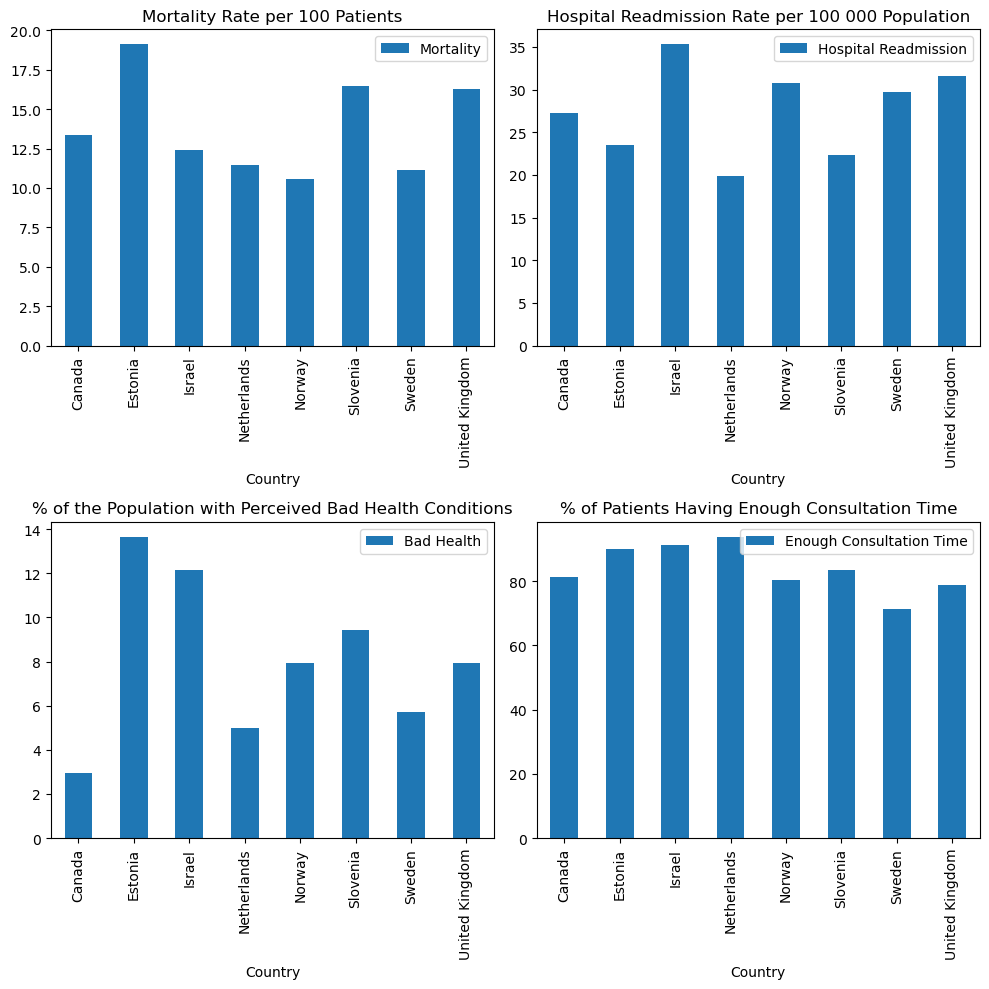

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0] = summary_qual_mor.plot.bar(ax=ax[0,0])
ax[0, 0].set_title("Mortality Rate per 100 Patients")
ax[0, 1] = summary_qual_re_hos.plot.bar(ax=ax[0, 1])
ax[0, 1].set_title("Hospital Readmission Rate per 100 000 Population")
ax[1, 0] = summary_bad_health.plot.bar(ax=ax[1,0])
ax[1, 0].set_title("% of the Population with Perceived Bad Health Conditions")
ax[1, 1] = summary_qual_doc.plot.bar(ax = ax[1,1])
ax[1, 1].set_title("% of Patients Having Enough Consultation Time")
plt.tight_layout()

### Health Workforce Migration

<AxesSubplot: xlabel='Country'>

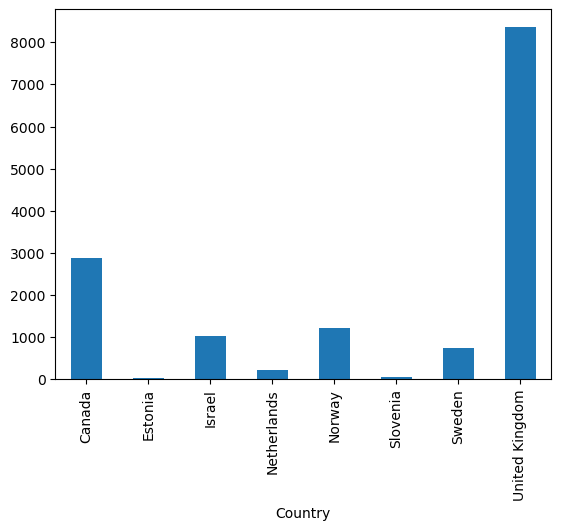

In [16]:
worker_migr_filtered = worker_migr[["Foreign-trained doctors - Annual inflow"]][worker_migr.index.get_level_values('Year') > 2014]
worker_migr_summary = worker_migr_filtered.groupby(['Country'])['Foreign-trained doctors - Annual inflow'].mean().fillna(0)
worker_migr_summary = worker_migr_summary[worker_migr_summary.index.get_level_values('Country').isin(common_countries)]
worker_migr_summary.plot.bar()

In [17]:
per_capita_gdp = pd.DataFrame( reference["/capita, US$ purchasing power parity"]["Gross domestic product (GDP)"])
per_capita_gdp = per_capita_gdp[per_capita_gdp.index.get_level_values('Year') > 2014]
per_capita_gdp_filtered = per_capita_gdp[per_capita_gdp.index.get_level_values('Country').isin(common_countries)]

per_capita_gdp_summary = pd.DataFrame(per_capita_gdp_filtered.groupby(['Country'])['Gross domestic product (GDP)'].mean()).rename(columns={'Gross domestic product (GDP)': 'GDP per Capita by US$ purchasing power parity'})


In [18]:
imm_qual = pd.merge(summary_qual_mor, summary_qual_re_hos, on = ['Country'])
imm_qual = pd.merge(imm_qual, summary_qual_doc, on = ['Country'])
imm_qual = pd.merge(imm_qual, summary_bad_health, on = ['Country'])
imm_qual = pd.merge(imm_qual, per_capita_gdp_summary, on = ['Country'])
imm_qual = pd.merge(imm_qual, worker_migr_summary, on = ['Country']) 
imm_qual = pd.merge(imm_qual, age_summary, on = ['Country']) 

In [19]:
correlation_matrix = imm_qual.corr()

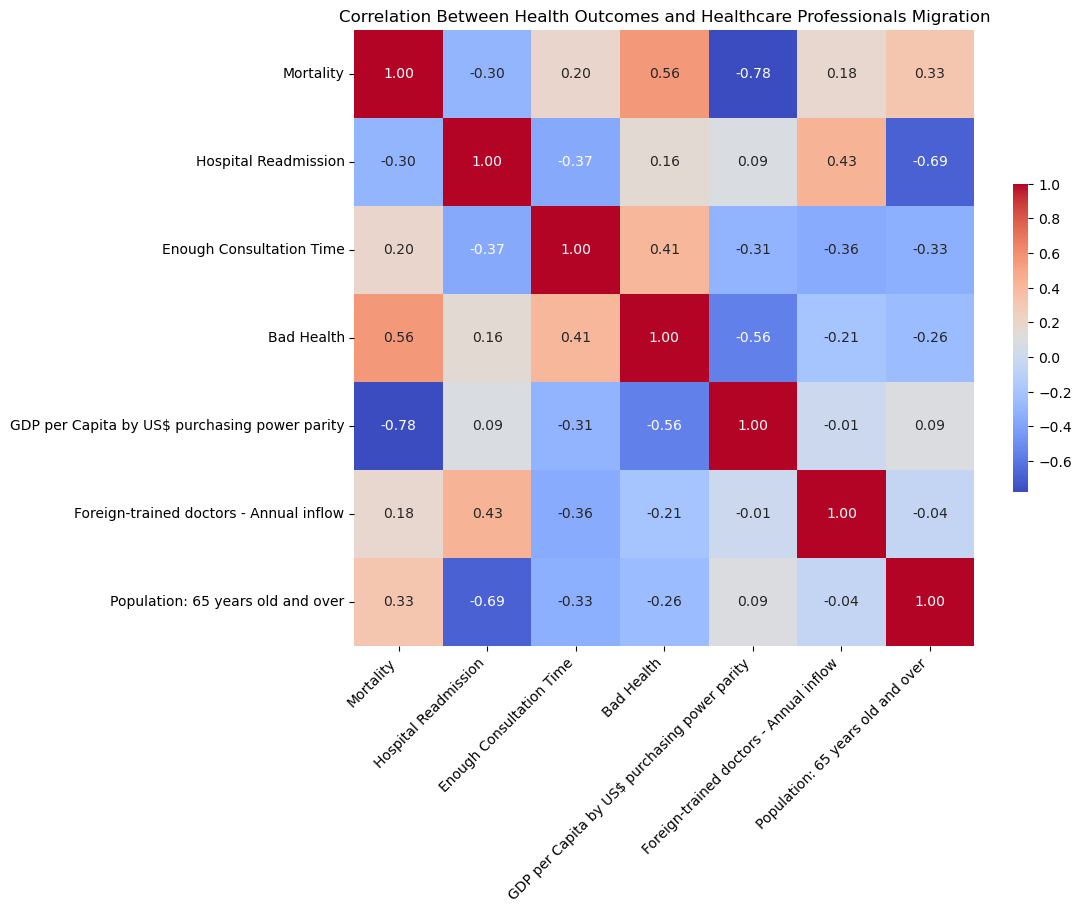

In [20]:
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Between Health Outcomes and Healthcare Professionals Migration')

plt.show()

In [21]:
imm_qual

,Mortality,Hospital Readmission,Enough Consultation Time,Bad Health,GDP per Capita by US$ purchasing power parity,Foreign-trained doctors - Annual inflow,Population: 65 years old and over
Country,,,,,,,
Canada,13.355556,27.222222,81.150000,2.957143,49574.8750,2884.571429,17.200000
Estonia,19.109524,23.452778,90.100000,13.650000,37545.9875,17.875000,19.625000
Israel,12.407143,35.295238,91.116667,12.157143,41010.8375,1022.500000,11.657143
Netherlands,11.462698,19.883333,93.742857,4.987500,58788.9750,212.285714,18.925000
Norway,10.547619,30.756667,80.200000,7.933333,70919.6875,1213.142857,17.087500
Slovenia,16.499206,22.327778,83.433333,9.412500,39840.6750,58.750000,19.537500
Sweden,11.167460,29.723810,71.350000,5.725000,55387.4625,748.333333,19.812500
United Kingdom,16.284259,31.597917,78.800000,7.920000,47589.0625,8362.714286,18.314286


In [22]:
from sklearn import linear_model


X = imm_qual[["Mortality", "Enough Consultation Time", "Bad Health"]]
y = imm_qual['Foreign-trained doctors - Annual inflow'] 

X = sm.add_constant(X)
doc_imm_model = sm.OLS(y, X)
doc_imm_result = doc_imm_model.fit()

print(doc_imm_result.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Foreign-trained doctors - Annual inflow   R-squared:                       0.252
Model:                                                 OLS   Adj. R-squared:                 -0.308
Method:                                      Least Squares   F-statistic:                    0.4500
Date:                                     Sun, 14 Apr 2024   Prob (F-statistic):              0.731
Time:                                             23:26:58   Log-Likelihood:                -73.164
No. Observations:                                        8   AIC:                             154.3
Df Residuals:                                            4   BIC:                             154.6
Df Model:                                                3                                         
Covariance Type:                                 nonrobust                                         


/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Results
Countries with a higher number of mortality, hospital admission, and readmission tend to have a lower number of migrant healthcare providers. However, this may be attributed to  

## Insurance, Healthcare Spending, and Remuneration as Predictive Factors of Healthcare Professional Migration

**Preliminary Analysis**

Had to remove GP salary due to lack of data

In [23]:
hlth_gdp_share = health_expen["Share of gross domestic product"]["Current expenditure on health (all functions)"]
inpt_gdp_share = health_expen["Share of gross domestic product"]["Inpatient curative and rehabilitative care"]
prev_gdp_share = health_expen["Share of gross domestic product"]["Preventive care"]
hlth_percap_ppp = health_expen["Per capita, current prices, current PPPs"]["Current expenditure on health (all functions)"]
inpt_percap_ppp = health_expen["Per capita, current prices, current PPPs"]["Inpatient curative and rehabilitative care"]
prev_percap_ppp = health_expen["Per capita, current prices, current PPPs"]["Preventive care"]
gp_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of general practitioners"]
nur_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of hospital nurses"]
spec_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of specialists"]
hosp_doc_pct = health_resor["% of total hospital employment (head counts)"]["Physicians employed in hospitals"]
hosp_nurmw_pct = health_resor["% of total hospital employment (head counts)"]["Professional nurses and midwives employed in hospitals"]
gov_hi_pct = social_proc["% of total population"]["Government/compulsory health insurance coverage"]
pop_cov_pct = social_proc["% of total population covered"]["Total public and primary voluntary health insurance coverage"]
for_doc_pct = worker_migr["% of foreign-trained doctors"]
for_nur_pct = worker_migr["% of foreign-trained nurses"]
for_doc_inf = worker_migr["Foreign-trained doctors - Annual inflow"]
for_nur_inf = worker_migr["Foreign-trained nurses - Annual inflow"]

In [24]:
doc_pct_pred_list = [hlth_gdp_share,inpt_gdp_share,prev_gdp_share,hlth_percap_ppp,inpt_percap_ppp,prev_percap_ppp,hosp_doc_pct,gp_sal_usd,spec_sal_usd,gov_hi_pct,for_doc_pct]
doc_pct_pred = pd.concat(doc_pct_pred_list,axis=1).dropna()
doc_pct_pred_corr = doc_pct_pred.corr()["% of foreign-trained doctors"]

doc_inf_pred_list = [hlth_gdp_share,inpt_gdp_share,prev_gdp_share,hlth_percap_ppp,inpt_percap_ppp,prev_percap_ppp,hosp_doc_pct,gp_sal_usd,spec_sal_usd,gov_hi_pct,for_doc_inf]
doc_inf_pred = pd.concat(doc_inf_pred_list,axis=1).dropna()
doc_inf_pred_corr = doc_inf_pred.corr()["Foreign-trained doctors - Annual inflow"]

nur_pct_pred_list = [hlth_gdp_share,inpt_gdp_share,prev_gdp_share,hlth_percap_ppp,inpt_percap_ppp,prev_percap_ppp,hosp_nurmw_pct,nur_sal_usd,gov_hi_pct,for_nur_pct]
nur_pct_pred = pd.concat(nur_pct_pred_list,axis=1).dropna()
nur_pct_pred_corr = nur_pct_pred.corr()["% of foreign-trained nurses"]

nur_inf_pred_list = [hlth_gdp_share,inpt_gdp_share,prev_gdp_share,hlth_percap_ppp,inpt_percap_ppp,prev_percap_ppp,hosp_nurmw_pct,nur_sal_usd,gov_hi_pct,for_nur_inf]
nur_inf_pred = pd.concat(nur_inf_pred_list,axis=1).dropna()
nur_inf_pred_corr = nur_inf_pred.corr()["Foreign-trained nurses - Annual inflow"]

In [25]:
print("Percentage of foreign-trained doctors \n" + str(doc_pct_pred_corr)+"\n")
print("Inflow of foreign-trained doctors \n" + str(doc_inf_pred_corr)+"\n")
print("Percentage of foreign-trained nurses \n" + str(nur_pct_pred_corr)+"\n")
print("Inflow of foreign-trained nurses \n" + str(nur_inf_pred_corr)+"\n")

Percentage of foreign-trained doctors 
Current expenditure on health (all functions)      0.458864
Inpatient curative and rehabilitative care         0.598169
Preventive care                                   -0.290847
Current expenditure on health (all functions)      0.194802
Inpatient curative and rehabilitative care         0.455260
Preventive care                                   -0.263656
Physicians employed in hospitals                   0.118962
Remuneration of general practitioners              0.173363
Remuneration of specialists                        0.456306
Government/compulsory health insurance coverage    0.146787
% of foreign-trained doctors                       1.000000
Name: % of foreign-trained doctors, dtype: float64

Inflow of foreign-trained doctors 
Current expenditure on health (all functions)      0.141576
Inpatient curative and rehabilitative care         0.541588
Preventive care                                    0.385864
Current expenditure on health (all

ValueError: x and y must be the same size

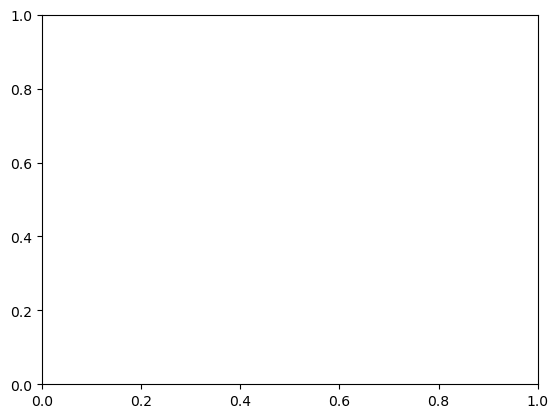

In [26]:
doc_inf_pred.plot("Preventive care","Foreign-trained doctors - Annual inflow","scatter")

In [27]:
x_docinf = doc_inf_pred.loc[:,~doc_inf_pred.columns.isin(["% of foreign-trained doctors"])]
y_docinf = doc_inf_pred["Foreign-trained doctors - Annual inflow"]

x_docinf = sm.add_constant(x_docinf)
x_docinf_model = sm.OLS(y_docinf, x_docinf)
x_docinf_result = x_docinf_model.fit()

print(x_docinf_result.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Foreign-trained doctors - Annual inflow   R-squared:                       1.000
Model:                                                 OLS   Adj. R-squared:                  1.000
Method:                                      Least Squares   F-statistic:                 2.181e+27
Date:                                     Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                                             23:27:04   Log-Likelihood:                 1101.3
No. Observations:                                       51   AIC:                            -2179.
Df Residuals:                                           39   BIC:                            -2155.
Df Model:                                               11                                         
Covariance Type:                                 nonrobust                                         


In [28]:
x_docinf = doc_inf_pred[["Current expenditure on health (all functions)","Remuneration of general practitioners","Remuneration of specialists","Government/compulsory health insurance coverage"]]
y_docinf = doc_inf_pred["Foreign-trained doctors - Annual inflow"]

x_docinf = sm.add_constant(x_docinf)
x_docinf_model = sm.OLS(y_docinf, x_docinf)
x_docinf_result = x_docpct_model.fit()

print(x_docinf_result.summary())

NameError: name 'x_docpct_model' is not defined

## Relationship Between Domestic and Foreign-Trained Medical Professionals
**Preliminary Analysis**

In [29]:
#create new column for percentage of domestically trained healthcare workers
#sum domestic trained doctors and nurses, divide by total
worker_migr['%_of_domestic_trained_healthcare_workers'] = (
    (worker_migr['Domestically-trained doctors'] + worker_migr['Domestically-trained nurses']) /
    (worker_migr['Total number of doctors'] + worker_migr['Total number of nurses'])
) * 100

worker_migr['%_of_foreign_trained_healthcare_workers'] = (
    (worker_migr['Foreign-trained doctors - Stock'] + worker_migr['Foreign-trained nurses - Stock']) /
    (worker_migr['Total number of doctors'] + worker_migr['Total number of nurses'])
) * 100


#worker_migr['%_of_workers_unknown_training'] = 100 - (worker_migr['%_of_foreign_trained_healthcare_workers']\
                                                    #+ worker_migr['%_of_domestic_trained_healthcare_workers'])


# Reset index
worker_migr= worker_migr.reset_index()

In [30]:
worker_migr_to_plot = worker_migr[['Country', 'Year', '%_of_domestic_trained_healthcare_workers',
                                    '%_of_foreign_trained_healthcare_workers']] \
                        .groupby('Country') \
                        .mean() \
                        .dropna() \
                        .reset_index()

worker_migr_to_plot.head()

Variable,Country,Year,%_of_domestic_trained_healthcare_workers,%_of_foreign_trained_healthcare_workers
0,Australia,2016.5,75.906449,21.387244
1,Austria,2016.0,89.054196,10.917625
2,Belgium,2016.0,94.815600,5.184400
3,Canada,2015.5,88.293546,11.062368
4,Chile,2016.5,89.164194,10.704136


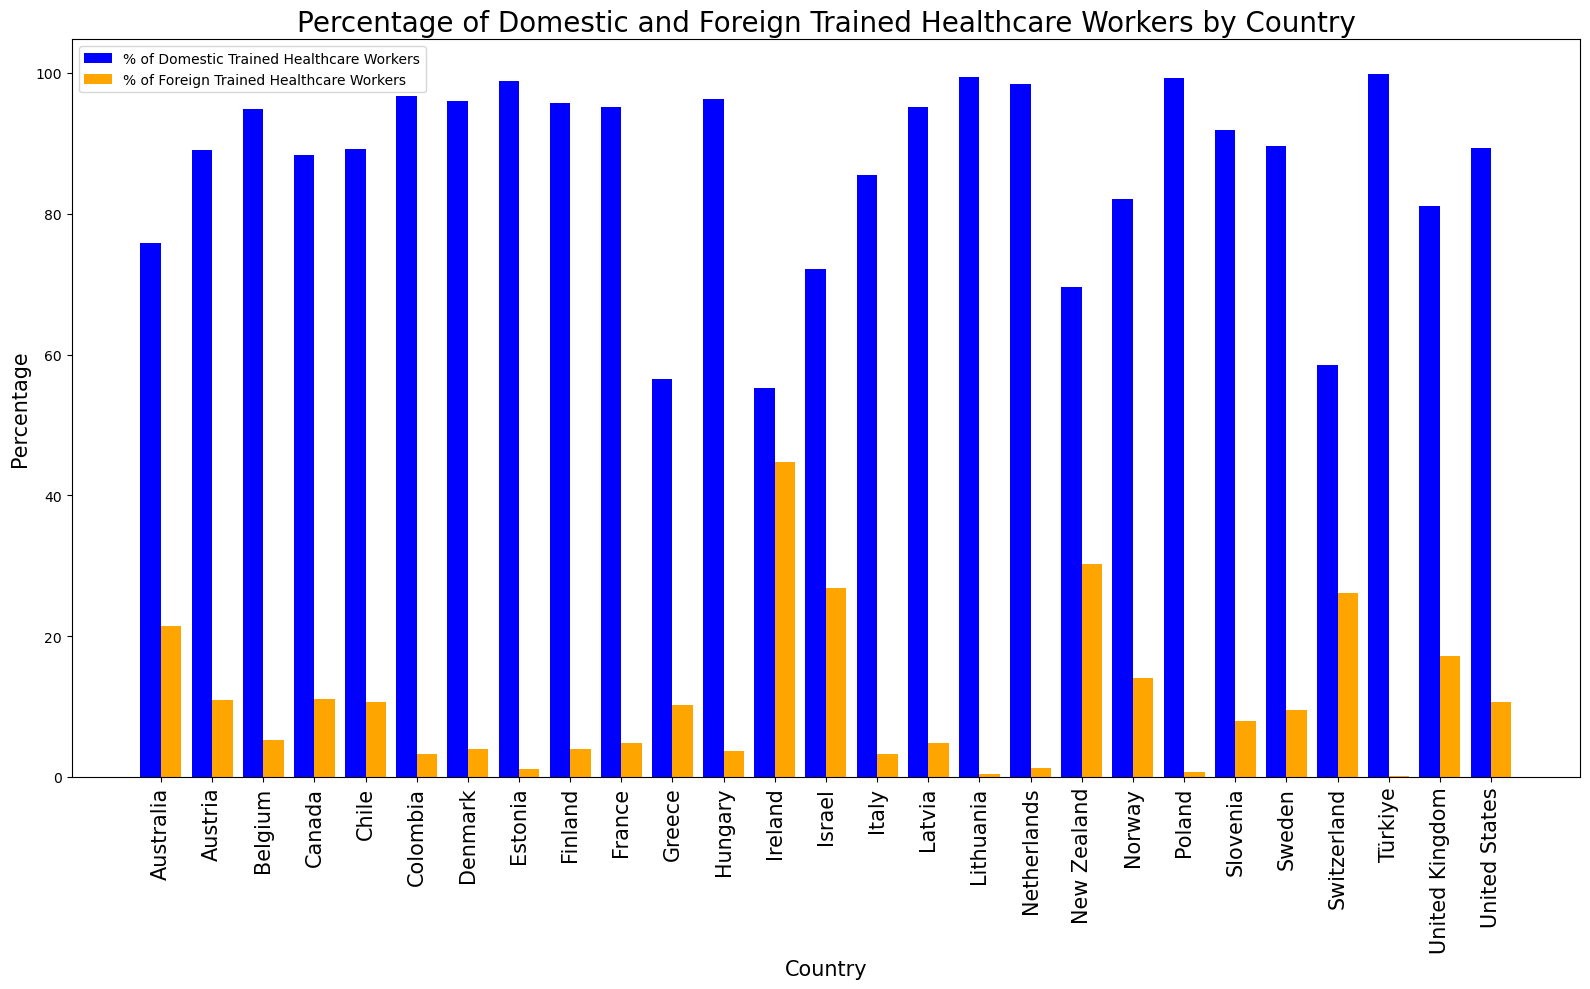

In [31]:
bar_width = 0.4

# bar positions
r1 = np.arange(len(worker_migr_to_plot['Country']))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(16, 10))

#domestic healthcare workers
plt.bar(r1, worker_migr_to_plot['%_of_domestic_trained_healthcare_workers'], color='blue', width=bar_width, label='% of Domestic Trained Healthcare Workers')

#foreign healthcare workers
plt.bar(r2, worker_migr_to_plot['%_of_foreign_trained_healthcare_workers'], color='orange', width=bar_width, label='% of Foreign Trained Healthcare Workers')

plt.xticks([r + bar_width/2 for r in range(len(worker_migr_to_plot['Country']))], worker_migr_to_plot['Country'], rotation=90, size = 15)

plt.xlabel('Country', size = 15)
plt.ylabel('Percentage', size = 15)
plt.title('Percentage of Domestic and Foreign Trained Healthcare Workers by Country', size = 20)
plt.legend()
plt.tight_layout()
plt.show()

## Maps

**Map of doctor inflow, map of foreign doctor percentage, map of nurse inflow, map of foreign nurse percentage**

In [32]:
map_data = worker_migr[['Country', 'Year', '%_of_domestic_trained_healthcare_workers',
                        '%_of_foreign_trained_healthcare_workers', "% of foreign-trained doctors",
                        "% of foreign-trained nurses", "Foreign-trained doctors - Annual inflow",
                        "Foreign-trained nurses - Annual inflow"
                       ]] \
            .groupby('Country') \
            .mean() \
            .reset_index()

map_data.tail()

Variable,Country,Year,%_of_domestic_trained_healthcare_workers,%_of_foreign_trained_healthcare_workers,% of foreign-trained doctors,% of foreign-trained nurses,Foreign-trained doctors - Annual inflow,Foreign-trained nurses - Annual inflow
31,Sweden,2015.0,89.587672,9.573370,26.929727,2.973000,781.545455,188.000000
32,Switzerland,2016.0,58.476899,26.113476,31.854667,23.173500,2100.769231,2423.230769
33,Türkiye,2012.5,99.792660,0.207340,0.200000,0.213333,1.333333,50.500000
34,United Kingdom,2015.5,81.102487,17.183752,29.358250,13.936667,7251.833333,7556.000000
35,United States,2015.5,89.407487,10.592513,24.874286,6.266667,7167.000000,6477.166667


In [33]:


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Replace 'United States of America' with 'United States' and 'Turkey' with 'Türkiye'
world['name'] = world['name'].replace({'United States of America': 'United States', 'Turkey': 'Türkiye'})



# Merge the world shapefile with your data
merged_data = world.merge(map_data, how='left', left_on='name', right_on='Country')

merged_data.head()

/tmp/ipykernel_205/1346113886.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Country,Year,%_of_domestic_trained_healthcare_workers,%_of_foreign_trained_healthcare_workers,% of foreign-trained doctors,% of foreign-trained nurses,Foreign-trained doctors - Annual inflow,Foreign-trained nurses - Annual inflow
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,2015.5,88.293546,11.062368,24.073833,7.880833,2813.5,2689.083333
4,328239523.0,North America,United States,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States,2015.5,89.407487,10.592513,24.874286,6.266667,7167.0,6477.166667


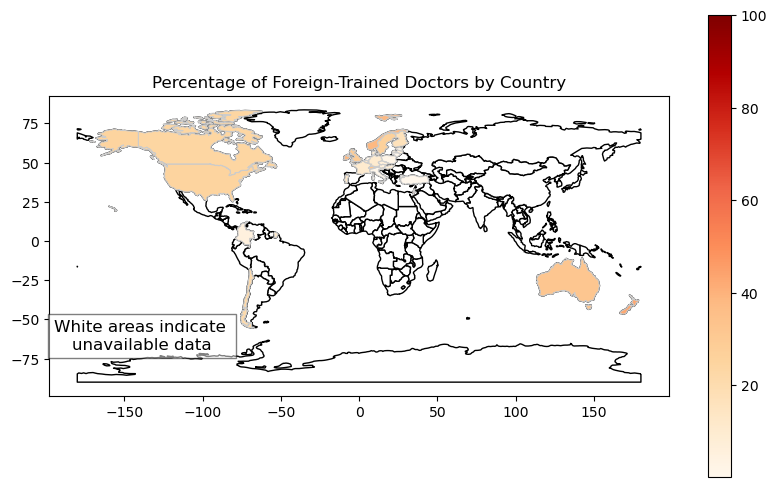

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world.plot(ax=ax, color='white', edgecolor='black')

merged_data.plot(column='% of foreign-trained doctors', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.text(0.15, 0.2, 'White areas indicate \nunavailable data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

ax.set_title('Percentage of Foreign-Trained Doctors by Country')
plt.show()


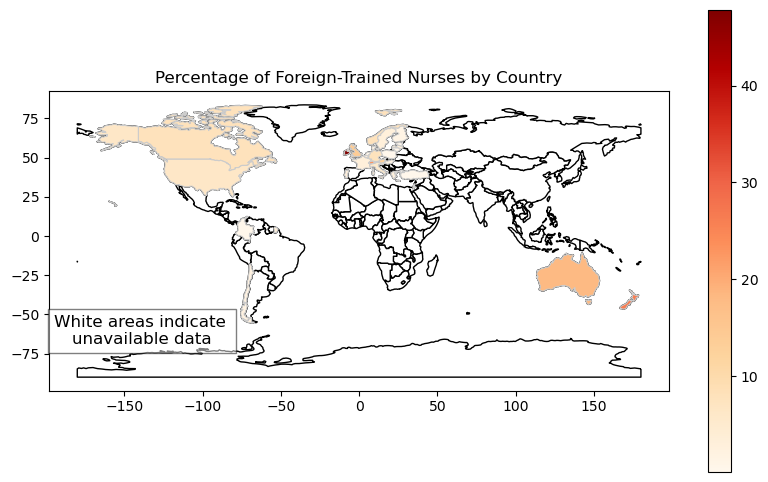

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world.plot(ax=ax, color='white', edgecolor='black')

merged_data.plot(column='% of foreign-trained nurses', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.text(0.15, 0.2, 'White areas indicate \nunavailable data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

ax.set_title('Percentage of Foreign-Trained Nurses by Country')
plt.show()

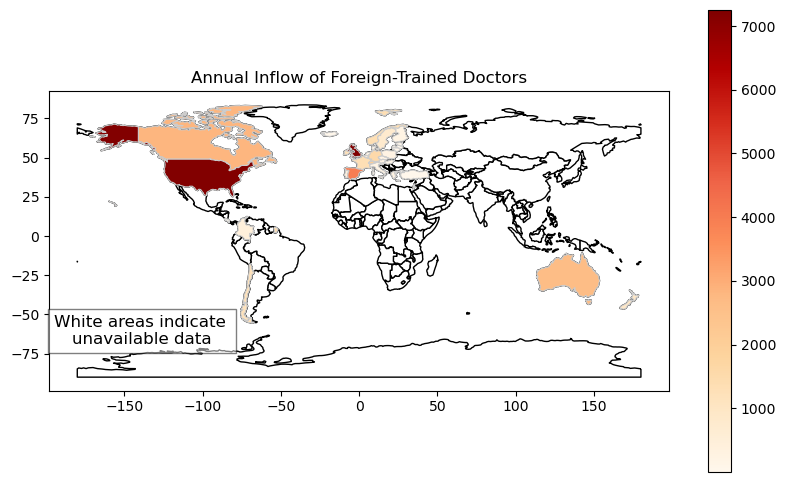

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world.plot(ax=ax, color='white', edgecolor='black')

merged_data.plot(column='Foreign-trained doctors - Annual inflow', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.text(0.15, 0.2, 'White areas indicate \nunavailable data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

ax.set_title('Annual Inflow of Foreign-Trained Doctors')
plt.show()

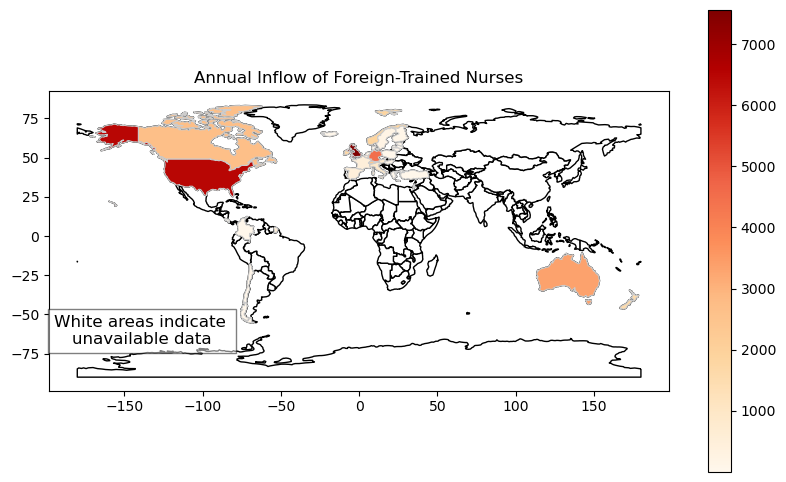

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world.plot(ax=ax, color='white', edgecolor='black')

merged_data.plot(column='Foreign-trained nurses - Annual inflow', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.text(0.15, 0.2, 'White areas indicate \nunavailable data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

ax.set_title('Annual Inflow of Foreign-Trained Nurses')
plt.show()

## References
Global Affairs Canada. (2017). Global Health and Development. Retrieved from https://www.international.gc.ca/world-monde/issues_development-enjeux_developpement/global_health-sante_mondiale/health_development-sante_developpement.aspx?
lang=eng

OECD (2023), International Migration Outlook 2023, OECD Publishing, Paris, https://doi.org/10.1787/b0f40584-en

OECD (2023), *Demographic References*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_DEMR

OECD (2023), *Economic References*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_ECOR

OECD (2023), *Health Expenditure and Financing*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=SHA

OECD (2023), *Healthcare Quality Indicators*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_HCQI

OECD (2023), *Healthcare Resources*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_REAC

OECD (2023), *Healthcare Utilization* OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROC

OECD (2023), *Social Protection*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROT

OECD (2023), *Health Workforce Migration*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_WFMI